In [38]:
# import the necessary packages
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import fnmatch
import natsort 
import glob
import math
import time
from skimage.metrics import mean_squared_error
import csv 
from PIL import Image

In [40]:
'''
    Đoạn code này dùng để đọc video và lưu các frame của video dưới dạng ảnh xám.
    vào thư mục data. Các frame được lưu với tên frame1.jpg, frame2.jpg, ...
    Các frame được lưu cách nhau frame_interval frame.
    Đầu vào:
        video_path: đường dẫn đến video
        output_dir: thư mục chứa các frame được lưu
        frame_interval: số frame giữa 2 frame được lưu
    Đầu ra:
        Các frame được lưu dưới dạng ảnh trong thư mục code/data
'''

video_path = "../dataset/video2.mp4" # Đường dẫn đến video
output_dir = '../frame' # Thư mục chứa các frame được lưu
frame_interval = 1 # Số frame giữa 2 frame được lưu

# Tạo thư mục chứa các frame nếu chưa tồn tại
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Đọc video
vid = cv2.VideoCapture(video_path)
if not vid.isOpened():
    print(f"Error: Could not open video {video_path}")
    exit(1)

# Lưu các frame dưới dạng ảnh xám
count = 0
image = 1
current_frame = 1

while True:
    success, frame = vid.read()
    if not success:
        print("Error: Could not read frame")
        break

    count += 1

    if count % frame_interval == 0:
        gray_image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        gray_image = gray_image[123:940, 239:2155]
        cv2.imwrite('../frame/frame' + str(image) + '.jpg', gray_image)
        image += 1

    # if count > 720:
    #     break
    current_frame += 1
vid.release()
cv2.destroyAllWindows()
print(f"Total frames processed: {count}")

Error: Could not read frame
Total frames processed: 751


Kích thước video:  (817, 1681, 3)
Số frame:  752
Kích thước ảnh:  (817, 1681, 3)


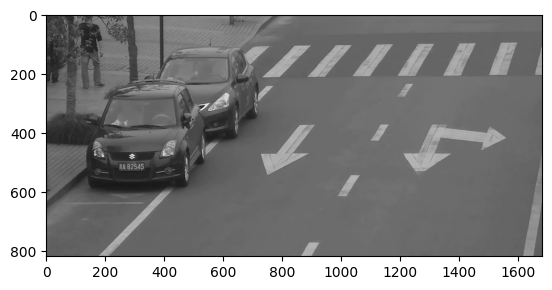

In [41]:
# Hiển thị frame đầu tiên để kiểm tra
frame = cv2.imread('../frame/frame1.jpg')
print("Kích thước video: ", frame.shape)
print("Số frame: ", image)
print("Kích thước ảnh: ", frame.shape)
plt.imshow(frame, cmap='gray')
plt.show()

In [42]:
'''
    Hàm pdf_value tính mật độ xác suất của 1 giá trị x theo phân phối Gaussian
    Đầu vào:
        x: giá trị cần tính mật độ xác suất
        u: giá trị trung bình của phân phối Gaussian
        sigma: độ lệch chuẩn của phân phối Gaussian
    Đầu ra:
        Giá trị mật độ xác suất tại x
'''
def pdf_value(x1,u1,sigma1):
  p=((x1-u1)**2)/(2*(sigma1**2))
  t = (1/np.sqrt((2*np.pi*(sigma1**2))))*(np.exp(-p))
  return t

'''
    Hàm Gaussian_Mixture thực hiện phân cụm Gaussian Mixture cho dãy giá trị x
    Đầu vào:
        x: dãy giá trị cần phân cụm
        u1: giá trị trung bình của cluster 1
        sigma1: độ lệch chuẩn của cluster 1
        u2: giá trị trung bình của cluster 2
        sigma2: độ lệch chuẩn của cluster 2
        w1: trọng số của cluster 1
        w2: trọng số của cluster 2
    Đầu ra:
        Giá trị trung bình của cluster mà giá trị x thuộc về
'''
def Gaussian_Mixture(x,u1,sigma1,u2,sigma2,w1,w2):
  mean1=u1
  mean2=u2
  weight1=w1
  weight2=w2
  SD1=sigma1
  SD2=sigma2
  count=0
  while (True):
    m1=mean1
    m2=mean2
    we1=weight1
    we2=weight2
    si1=SD1
    si2=SD2
    count=count+1

    # print(mean1,SD1,mean2,SD2,weight1,weight2)

    prob_array_cluster1=[]  # pdf
    prob_array_cluster2=[]
    for i in range(len(x)):
      prob_array_cluster1.append(pdf_value(x[i],mean1,SD1)) # calculating the pdf values coorsponding to each entry in x
      prob_array_cluster2.append(pdf_value(x[i],mean2,SD2))

    prob_element_in_cluster1=[] #  b_k
    prob_element_in_cluster2=[]
    for i in range(len(x)):
      # calculating bayers probability of x[i] belonging to both the clusters
      prob_element_in_cluster1.append((prob_array_cluster1[i]*weight1)/(prob_array_cluster1[i]*weight1+prob_array_cluster2[i]*weight2))
      prob_element_in_cluster2.append((prob_array_cluster2[i]*weight2)/(prob_array_cluster1[i]*weight1+prob_array_cluster2[i]*weight2))

    weight1=sum(prob_element_in_cluster1)/2  # updating the weights
    weight2=sum(prob_element_in_cluster2)/2

    d1=0  # sigma
    d2=0
    for i in range(len(x)):
      d1 = d1+prob_element_in_cluster1[i]*(x[i]-mean1)*(x[i]-mean1)
      d2 = d2+prob_element_in_cluster2[i]*(x[i]-mean2)*(x[i]-mean2)
    SD1=np.sqrt(d1/(2*weight1)) # upadting the varience/standard deviation
    SD2=np.sqrt(d2/(2*weight2))

    t1=0   # u_k
    t2=0
    for i in range(len(x)):
      t1 = t1+prob_element_in_cluster1[i]*x[i]
      t2 = t2+prob_element_in_cluster2[i]*x[i]
    mean1=t1/(2*weight1)
    mean2=t2/(2*weight2) # updating the mean values
    # convergence condition
    if (abs(mean1-m1)<0.1 or abs(mean2-m2)<0.1 or mean1>10000000 or mean2>10000000 or weight1>10000000 or weight1>10000000 or SD1>1000000 or SD2>10000000 or count>15):
      if count>15:
        return (sum(x)/len(x)) # if the algorithm doesnt converge, mean is returned as the output
        # return 255

      elif weight1>weight2:
        # print(mean1)
        #print(mean1, mean2)
        return mean1

      else:
        # print(mean2)
        #print(mean1, mean2)
        return mean2

In [43]:
'''
    Đoạn code này dùng để đọc các ảnh từ thư mục data và lưu vào mảng array.
    Mỗi ảnh được chuyển về ảnh xám và lưu dưới dạng ma trận numpy.
    Đầu vào:
        Đọc ảnh từ thư mục data chứa các frame của video
    Đầu ra:
        Mảng array chứa các ảnh
        Mỗi ảnh là 1 ma trận numpy
        Kích thước mảng array là (số ảnh, chiều cao ảnh, chiều rộng ảnh)
'''
array = []
IMAGE_DIR = '../frame'

image_names = []
image_dictionary = []

image_1D = []
for root, dirnames, filenames in os.walk(IMAGE_DIR):
    for filename in fnmatch.filter(filenames, "*.*"):
        image_names.append(os.path.join(root, filename))

for idx,image_name in enumerate(image_names):
    img = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE).astype(np.float64)
    # img.reshape()
    img = cv2.resize(img, (240,108), interpolation = cv2.INTER_AREA)
    array.append(img)



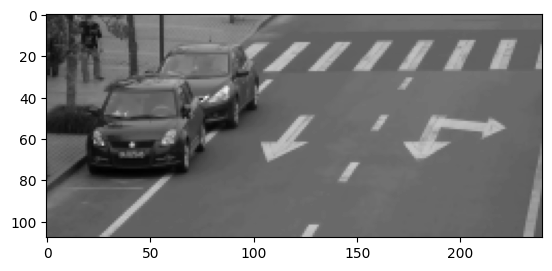

Kích thước ảnh:  (108, 240)


In [44]:
# Hiển thị ảnh đầu tiên trong array để kiểm tra
plt.imshow(array[0], cmap='gray')
plt.show()
print("Kích thước ảnh: ", array[0].shape)


In [45]:
count = 0

final_array = np.zeros((108,240))

for i in range(len(array[0])): #rows
  for j in range(len(array[0][0])): #cols
    x = []
    for e in array: #frames
      x.append(e[i][j])
    summ = sum(x)
    avg = summ/len(x)
    xx = (Gaussian_Mixture(x,(avg),3,(avg*2),4,1/2,1/2)) # appling gaussian mixture to each pixel location values across all the frames to generate the background 
    final_array[i][j] = xx; # Extracted background
# print(final_array)

C:\Users\DELL\AppData\Local\Temp\ipykernel_1148\1761781388.py:57: RuntimeWarning: invalid value encountered in scalar divide
  prob_element_in_cluster1.append((prob_array_cluster1[i]*weight1)/(prob_array_cluster1[i]*weight1+prob_array_cluster2[i]*weight2))
C:\Users\DELL\AppData\Local\Temp\ipykernel_1148\1761781388.py:58: RuntimeWarning: invalid value encountered in scalar divide
  prob_element_in_cluster2.append((prob_array_cluster2[i]*weight2)/(prob_array_cluster1[i]*weight1+prob_array_cluster2[i]*weight2))
C:\Users\DELL\AppData\Local\Temp\ipykernel_1148\1761781388.py:69: RuntimeWarning: invalid value encountered in scalar divide
  SD2=np.sqrt(d2/(2*weight2))
C:\Users\DELL\AppData\Local\Temp\ipykernel_1148\1761781388.py:77: RuntimeWarning: invalid value encountered in scalar divide
  mean2=t2/(2*weight2) # updating the mean values


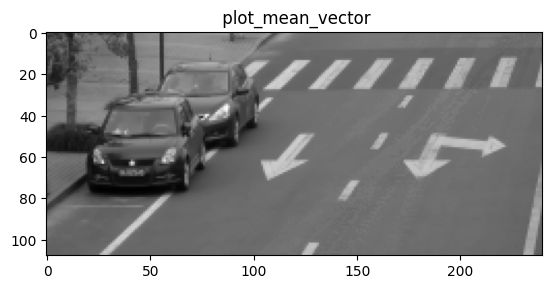

In [47]:

fig,axarr = plt.subplots()
axarr.set_title(" plot_mean_vector")
# avg_image = np.reshape(final_array, (240,108))

axarr.imshow(final_array, cmap=plt.cm.gray)
plt.show()

dim1:  (108, 240)
dim:  (108, 240)


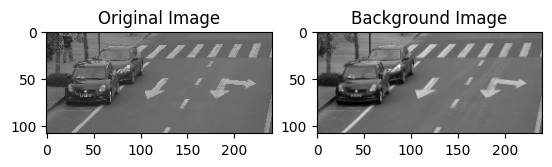

In [48]:
image=cv2.imread('../frame/frame6.jpg')
image2 = cv2.resize(image, (240,108),
               interpolation = cv2.INTER_NEAREST)
gray_image = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
dim1 = gray_image.shape
print("dim1: ", dim1)
dim = final_array.shape
print("dim: ", dim)
plt.subplot(1,2,1)
plt.imshow(image2, cmap='gray')
plt.title("Original Image")
plt.subplot(1,2,2)
plt.title("Background Image")
plt.imshow(final_array, cmap='gray')
plt.show()
gray_image = np.asarray(gray_image, np.float64)
final_array = np.asarray(final_array, np.float64)
image_final = cv2.absdiff(gray_image, final_array)

In [49]:

if not os.path.exists('./answer'):
    os.makedirs('./answer')
    
img_array = []

for p in range(1,len(array)+1):
  img1 = cv2.imread('../frame/frame' + str(p) + '.jpg')
  gray_image = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
  # print((np.shape(gray_image)))
  print("gray_image: ", gray_image)
  gray_image = cv2.resize(gray_image, (240,108), interpolation = cv2.INTER_AREA)

  # subtracting the background from the original frames  
  m = np.zeros((108,240))
  for i in range(len(final_array)):
    for j in range(len(final_array[0])):
      diff = final_array[i][j] - gray_image[i][j]
      if (abs(diff)>30): #threshold to check similarity betwwen two pixels for pixel classification as either foreground or background
        m[i][j]= gray_image[i][j]
      else:
        m[i][j] = 100
  # print("m: ", m)
  cv2.imwrite('./answer/frame' + str(p) + '.jpg', m)
  height, width = m.shape
  size = (width,height)
  img_array.append(m)
  # cv2_imshow(m)
  # plt.imshow(m, cmap='gray')
  # plt.show()
   

gray_image:  [[ 67  68  65 ... 108 108 108]
 [ 72  72  64 ... 108 108 108]
 [ 73  73  68 ... 108 108 108]
 ...
 [ 95  95  95 ...  94  94  94]
 [ 97  96  96 ...  94  94  94]
 [ 95  95  95 ...  94  94  94]]
gray_image:  [[ 67  68  65 ... 108 108 108]
 [ 72  72  64 ... 108 108 108]
 [ 73  73  68 ... 108 108 108]
 ...
 [ 95  95  95 ...  94  94  94]
 [ 97  96  96 ...  94  94  94]
 [ 95  95  95 ...  94  94  94]]
gray_image:  [[ 67  68  65 ... 108 108 108]
 [ 72  72  64 ... 108 108 108]
 [ 73  73  68 ... 108 108 108]
 ...
 [ 95  95  95 ...  94  94  94]
 [ 97  96  96 ...  94  94  94]
 [ 95  95  95 ...  94  94  94]]
gray_image:  [[ 57  60  60 ... 108 108 108]
 [ 60  62  61 ... 108 108 108]
 [ 66  66  65 ... 108 108 108]
 ...
 [ 96  96  95 ...  94  94  94]
 [ 96  96  96 ...  94  94  94]
 [ 95  94  94 ...  94  94  94]]
gray_image:  [[ 69  67  70 ... 108 108 108]
 [ 68  69  75 ... 108 108 108]
 [ 67  64  65 ... 108 108 108]
 ...
 [ 96  96  95 ...  94  94  94]
 [ 96  96  96 ...  94  94  94]
 [ 95  

In [50]:
img_array = []
for filename in glob.glob('./answer/*.jpg'):

    img_array.append(filename)
sorted_arr = natsort.natsorted(img_array)

In [37]:
# out = cv2.VideoWriter('project.avi',cv2.VideoWriter_fourcc(*'DIVX'), 8, size)
# for i in range(len(sorted_arr)):
#   out.write(cv2.imread(sorted_arr[i]))
# out.release()

In [51]:
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Mã codec cho MP4
out = cv2.VideoWriter('../result/result.mp4', fourcc, 25, size)

for i in range(len(sorted_arr)):
    out.write(cv2.imread(sorted_arr[i]))

out.release()

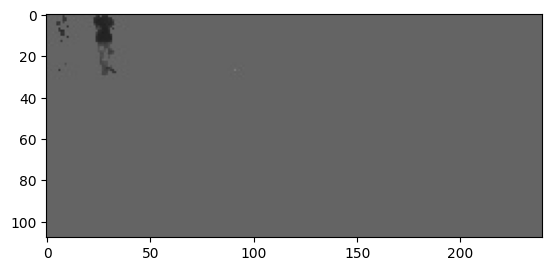

In [52]:
plt.imshow(cv2.imread('./answer/frame27.jpg')) # Output
plt.show()

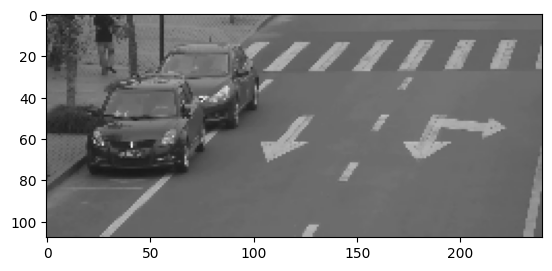

In [53]:
img = cv2.imread('../frame/frame27.jpg')  # Raw Frame
img = cv2.resize(img, (240,108))
plt.imshow(img)
plt.show()

In [56]:
if not os.path.exists('../frames_for_comparison'):
    os.makedirs('../frames_for_comparison')
    
img_array = []

for p in range(1,len(array)+1):
  img1 = cv2.imread('../frame/frame' + str(p) + '.jpg')
  gray_image = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
  # print((np.shape(gray_image)))
  gray_image = cv2.resize(gray_image, (240,108), interpolation = cv2.INTER_AREA)


  m = np.zeros((108,240))
  for i in range(len(final_array)):
    for j in range(len(final_array[0])):
      diff = final_array[i][j] - gray_image[i][j] # # subtracting the background from the original frames to generate only black and white foreground for comparison with built-in function
      if (abs(diff)>30):
        m[i][j]= 255
      else:
        m[i][j] = 0
  # print(m)
  cv2.imwrite('../frames_for_comparison/frame' + str(p) + '.jpg', m)
  height, width = m.shape
  size = (width,height)
  img_array.append(m)

In [59]:
vid = cv2.VideoCapture("../dataset/video2.mp4")
fgbg = cv2.createBackgroundSubtractorMOG2()

currentframe=1
count = 0
image = 1

RMSE=[]
while(True):
    success, frame = vid.read()
    if not success:
        print("Error: Could not read frame")
        break
    count += 1

    if count%1 == 0:
      gray_image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
      gray_image = gray_image[123:940, 239:2155]
      fgmask = fgbg.apply(gray_image) # in-built function for foreground generation

      gray_image = cv2.resize(gray_image, (240,108))
      fgmask = cv2.resize(fgmask, (240,108))
      # fgmask = fgmask.convert('L')
      # fgmask = cv2.cvtColor(fgmask, cv2.COLOR_BGR2GRAY)
      # gray_image = cv2.cvtColor(fgmask, cv2.COLOR_BGR2GRAY)
      # cv2_imshow(frame)
      
      our_image = cv2.imread('../frames_for_comparison/frame' + str(image) + '.jpg')
      our_image = cv2.cvtColor(our_image, cv2.COLOR_BGR2GRAY)
      # print('our foreground')
      # plt.imshow(our_image, cmap='gray')
      # plt.show()
      m = np.zeros((108,240))
      for i in range(len(final_array)):
        for j in range(len(final_array[0])):
          diff = fgmask[i][j]
          if (diff>10):
            m[i][j]= 255
          else:
            m[i][j] = 0
      # print('in-built function foreground')
      # plt.imshow(m, cmap='gray')
      # plt.show()
      dim1 = our_image.shape
      dim2 = gray_image.shape
      RMSE.append(math.sqrt(mean_squared_error(our_image, m))) # comparing both the generated foregrounds
      # print(mean_squared_error(fgmask, cv2.imread('/content/answer/frame' + str(image) + '.jpg') ) )
      # cv2.imwrite('./data/frame' + str(image) + '.jpg', gray_image)
      image += 1
      # cv2.imwrite('./roughdata/frame' + str(currentframe) + '.jpg', frame)

    # if count > 720:
    #     break

    currentframe += 1

# webCam.release()
a=RMSE[21:len(RMSE)-3] # storing the foregrounds in an array
cv2.destroyAllWindows()

Error: Could not read frame


In [60]:
# Storing RMSE values in csv file
x=[]
for i in a:
  x.append([i])
import csv
with open("MSE.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(x)
minimum=min(a)
maximum=max(a)


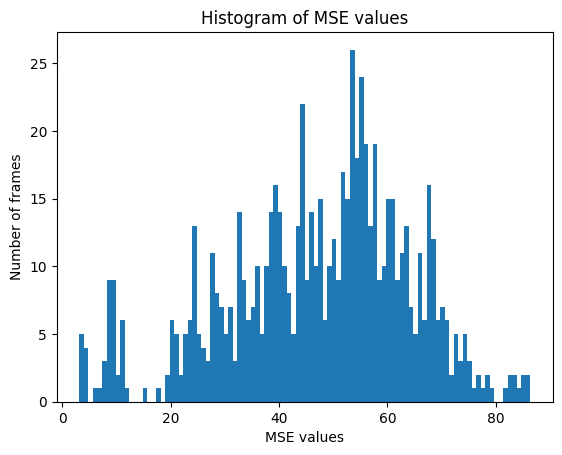

In [64]:
# Vẽ histogram của MSE value dạng cột
# Trục x: giá trị MSE chi tiết, độ chi tiết 
# Trục y: số frame tương ứng với giá trị MSE
plt.hist(a, bins=100)
plt.title('Histogram of MSE values')
plt.xlabel('MSE values')
plt.ylabel('Number of frames')
plt.show()



In [62]:
print("Maximum MSE between two frames is: " + str(maximum)) 
print("Minimum MSE between two frames is: " + str(minimum))
# It will change as the total number of frames change. 
# In the report, MSE is reported when all the video frames are taken(696).
# Here, the result is only for 72 frames.

Maximum MSE between two frames is: 86.36785984674029
Minimum MSE between two frames is: 3.167762968124702
